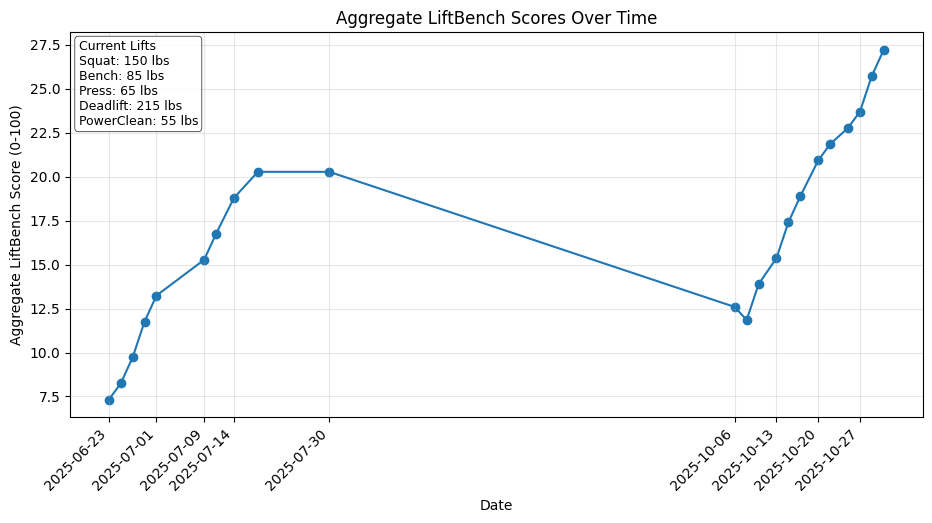

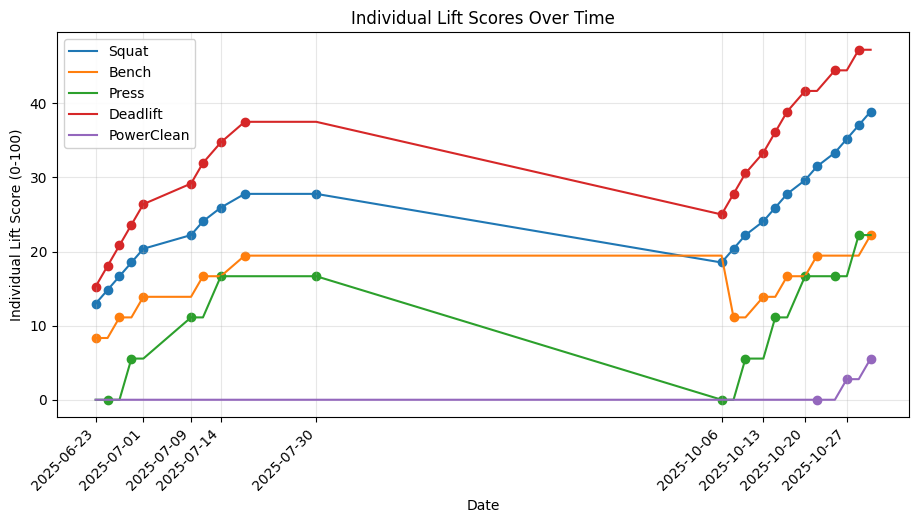

In [71]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd

# Goals for each lift and BASE
BASE = 45.0
GOALS = {"Squat":315, "Bench":225, "Press":135, "Deadlift":405, "PowerClean":225}

# Function to calculate score
def score(series: pd.Series, goal: float) -> pd.Series:
    """Compute a score for each value in the series based on the goal value."""
    return ((series - BASE) / (goal - BASE) * 100).clip(0, 100)

# User inputted data here
data = [
    # Summer lifts
    ("2025-06-23", {
        "Squat": 80,
        "Bench": 60,
        "Deadlift": 100,
    }),
    ("2025-06-25", {
        "Squat": 85,
        "Press": 45,
        "Deadlift": 110,
    }),
    ("2025-06-27", {
        "Squat": 90,
        "Bench": 65,
        "Deadlift": 120,
    }),
    ("2025-06-29", {
        "Squat": 95,
        "Press": 50,
        "Deadlift": 130,
    }),
    ("2025-07-01", {
        "Squat": 100,
        "Bench": 70,
        "Deadlift": 140,
    }),
    ("2025-07-09", {
        "Squat": 105,
        "Press": 55,
        "Deadlift": 150,
    }),
    ("2025-07-11", {
        "Squat": 110,
        "Bench": 75,
        "Deadlift": 160,
    }),
    ("2025-07-14", {
        "Squat": 115,
        "Press": 60,
        "Deadlift": 170,
    }),
    ("2025-07-18", {
        "Squat": 120,
        "Bench": 80,
        "Deadlift": 180,
    }),
    ("2025-07-30", {
        "Squat": 120,
        "Press": 60,
    }),

    # Fall lifts
    ("2025-10-06", {
        "Squat": 95,
        "Press": 45,
        "Deadlift": 135,
    }),
    ("2025-10-08", {
        "Squat": 100,
        "Bench": 65,
        "Deadlift": 145,
    }),
    ("2025-10-10", {
        "Squat": 105,
        "Press": 50,
        "Deadlift": 155,
    }),
    ("2025-10-13", {
        "Squat": 110,
        "Bench": 70,
        "Deadlift": 165,
    }),
    ("2025-10-15", {
        "Squat": 115,
        "Press": 55,
        "Deadlift": 175,
    }),
    ("2025-10-17", {
        "Squat": 120,
        "Bench": 75,
        "Deadlift": 185,
    }),
    ("2025-10-20", {
        "Squat": 125,
        "Press": 60,
        "Deadlift": 195,
    }),
    ("2025-10-22", {
        "Squat": 130,
        "Bench": 80,
        "PowerClean": 45,
    }),
    ("2025-10-25", {
        "Squat": 135,
        "Press": 60,
        "Deadlift": 205,
    }),
    ("2025-10-27", {
        "Squat": 140,
        "PowerClean": 50,
    }),
    ("2025-10-29", {
        "Squat": 145,
        "Press": 65,
        "Deadlift": 215,
    }),
    ("2025-10-31", {
        "Squat": 150,
        "Bench": 85,
        "PowerClean": 55,
    }),
]

# Turn data into a pandas DataFrame
rows = []
for date, values in data:
    row = {"Date": pd.to_datetime(date)}
    row.update(values)
    rows.append(row)
df = pd.DataFrame(rows).set_index("Date").sort_index()

# Days where any lift was performed
performed = df.notna()

# Fill in missing values with the previous value, and fill in missing values with BASE
df_filled = df.ffill().fillna(BASE)

# Calculate scores for each lift and the overall LiftBench
scores = pd.DataFrame(
    {lift: score(df_filled[lift], GOALS[lift]) for lift in GOALS},
    index=df_filled.index,
)
lift_cols = list(GOALS)
scores["LiftBench"] = scores[lift_cols].mean(axis=1)

# Create the figure and plot the LiftBench
fig, ax = plt.subplots(figsize=(11, 5))
ax.plot(scores.index, scores["LiftBench"])

# Mark the session days
session_days = performed.any(axis=1)
ax.scatter(
    scores.index[session_days],
    scores["LiftBench"][session_days],
)

# Add a title, labels, and a grid
plt.title("Aggregate LiftBench Scores Over Time")
plt.xlabel("Date")
plt.ylabel("Aggregate LiftBench Score (0-100)")
plt.grid(visible=True, alpha=0.3)

# Group by weeks that START Monday (i.e., weeks END Sunday => "W-SUN")
first_session_each_week = (
    scores.index.to_series()
    .groupby(scores.index.to_period("W-SUN"))
    .min()
    .sort_values()
)

# Use only those dates as x-ticks, rotate 45°
ax.set_xticks(first_session_each_week.tolist())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

# Get the latest lift values
latest_w = df_filled.iloc[-1][lift_cols]

# Add the latest lift values to the plot
labels = [f"{lift}: {int(latest_w[lift])} lbs" for lift in GOALS]
text = "\n".join(labels)
ax.text(
    0.01,
    0.98,
    "Current Lifts\n" + text,
    transform=ax.transAxes,
    va="top",
    ha="left",
    bbox={"boxstyle": "round", "facecolor": "white", "alpha": 0.9, "linewidth": 0.5},
    fontsize=9,
)

# Save the figure
plt.savefig("plots/aggregate_liftbench", dpi=1000)

# Create the figure for individual lifts
fig, ax = plt.subplots(figsize=(11, 5))

# Plot each lift
for lift in lift_cols:
    ax.plot(
        scores.index,
        scores[lift],
        label=lift,
    )
    idx = df.index[performed[lift]]
    ax.scatter(
        idx,
        scores.loc[idx, lift],
    )

# Add a title, labels, a grid, and a legend
ax.set_title("Individual Lift Scores Over Time")
ax.set_xlabel("Date")
ax.set_ylabel("Individual Lift Score (0-100)")
ax.grid(visible=True, alpha=0.3)
ax.legend(loc="upper left", frameon=True, framealpha=0.9)

# Group by weeks that START Monday (i.e., weeks END Sunday => "W-SUN")
first_session_each_week = (
    scores.index.to_series()
    .groupby(scores.index.to_period("W-SUN"))
    .min()
    .sort_values()
)

# Use only those dates as x-ticks, rotate 45°
ax.set_xticks(first_session_each_week.tolist())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

# Save the figure
plt.savefig("plots/individual_liftbend", dpi=1000)